In [1]:
!pip install ipaddress

  Using cached ipaddress-1.0.23-py2.py3-none-any.whl.metadata (923 bytes)
Using cached ipaddress-1.0.23-py2.py3-none-any.whl (18 kB)


# 1. Loading Libraries:

In [2]:
from sklearn.preprocessing import OneHotEncoder
import ipaddress
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
import matplotlib.cm as cm

In [3]:
import json
import modin.pandas as pd
import ray

ray_info = ray.init(
    _system_config={
    "object_spilling_config": json.dumps(
        {"type": "filesystem", "params": {"directory_path": "/mnt/sagemaker-nvme/ray_data_preprocessing_spelling"}},
    )
    },
    object_store_memory=(214748364800), # Allocates 200 GB to Ray Plasma memory, which stores object on available memory space.
    _temp_dir="/mnt/sagemaker-nvme/ray_temp",
    _plasma_directory="/mnt/sagemaker-nvme/ray_temp_plasma",
    ignore_reinit_error=True
)

2024-10-01 19:26:18,838	INFO services.py:2034 -- object_store_memory is not verified when plasma_directory is set.
2024-10-01 19:26:18,986	INFO worker.py:1762 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8267 
(raylet) Spilled 22617 MiB, 917 objects, write throughput 206 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(raylet) Spilled 22765 MiB, 1134 objects, write throughput 204 MiB/s.
(raylet) Spilled 33141 MiB, 3443 objects, write throughput 222 MiB/s. [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(raylet) Spilled 101899 MiB, 8566 objects, write throughput 441 MiB/s.
(raylet) Spilled 144669 MiB, 10499 objects, write throughput 616 MiB/s.
(remote_exec_func pid=19022) FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be remov

In [4]:
ray_info

RayContext(dashboard_url='127.0.0.1:8267', python_version='3.11.9', ray_version='2.31.0', ray_commit='{{RAY_COMMIT_SHA}}')

In [5]:
ray_info.address_info

{'node_ip_address': '169.255.255.2',
 'raylet_ip_address': '169.255.255.2',
 'redis_address': None,
 'object_store_address': '/mnt/sagemaker-nvme/ray_temp/session_2024-10-01_19-26-16_907376_30883/sockets/plasma_store',
 'raylet_socket_name': '/mnt/sagemaker-nvme/ray_temp/session_2024-10-01_19-26-16_907376_30883/sockets/raylet',
 'webui_url': '127.0.0.1:8267',
 'session_dir': '/mnt/sagemaker-nvme/ray_temp/session_2024-10-01_19-26-16_907376_30883',
 'metrics_export_port': 57663,
 'gcs_address': '169.255.255.2:58756',
 'address': '169.255.255.2:58756',
 'dashboard_agent_listen_port': 52365,
 'node_id': 'ae9e6147ad1a5cd6859c1fa09f8398ea6972113ba7bb32f1ab264a0c'}

# 2. Downloading files:

In [6]:
NVMe_PATH = '/mnt/sagemaker-nvme/'
training_file_name =  "combined_training_data.csv"
testing_file_name = "combined_testing_data.csv"

In [7]:
%%time

NVMe_Training_file_Path = NVMe_PATH+training_file_name
NVMe_Testing_file_Path = NVMe_PATH+testing_file_name

if os.path.exists(NVMe_Training_file_Path):
    pass
else:
    !aws s3 cp s3://melbahae-capstone/Datasets/combined_training_data.csv /mnt/sagemaker-nvme/

if os.path.exists(NVMe_Testing_file_Path):
    pass
else:
    !aws s3 cp s3://melbahae-capstone/Datasets/combined_testing_data.csv /mnt/sagemaker-nvme/

download: s3://melbahae-capstone/Datasets/combined_training_data.csv to ../../../mnt/sagemaker-nvme/combined_training_data.csv
download: s3://melbahae-capstone/Datasets/combined_testing_data.csv to ../../../mnt/sagemaker-nvme/combined_testing_data.csv
CPU times: user 5.18 s, sys: 3.75 s, total: 8.93 s
Wall time: 1min 23s


# 1. Loading data:

In [8]:
%%time

training_df = pd.read_csv("/mnt/sagemaker-nvme/combined_training_data.csv", low_memory=False)

CPU times: user 14.9 s, sys: 13.3 s, total: 28.2 s
Wall time: 1min 40s


Data types of partitions are different! Please refer to the troubleshooting section of the Modin documentation to fix this issue.


In [9]:
%%time

testing_df = pd.read_csv("/mnt/sagemaker-nvme/combined_testing_data.csv", low_memory=False)

CPU times: user 5.78 s, sys: 6.22 s, total: 12 s
Wall time: 31.5 s


In [10]:
original_training  = training_df.copy()

In [11]:
original_testing  = testing_df.copy()

In [12]:
original_training.isna().sum().sum()

0

In [13]:
original_testing.isna().sum().sum()

0

# 2. Validating dataframes columns and their type:

In [15]:
training_df.shape, testing_df.shape

((50052497, 73), (19963266, 73))

In [16]:
training_df.head()

Source IP  Source Port Destination IP  Destination Port Protocol  \
0  172.16.0.5        58445   192.168.50.1              4463      UDP   
1  172.16.0.5        36908   192.168.50.1              9914      UDP   
2  172.16.0.5        41727   192.168.50.1             32361      UDP   
3  172.16.0.5        55447   192.168.50.1              5691      UDP   
4  172.16.0.5        58794   192.168.50.1             56335      UDP   

                    Timestamp  Flow Duration  Total Fwd Packets  \
0  2018-12-01 13:04:45.928673              1                  2   
1  2018-12-01 13:04:45.928913              1                  2   
2  2018-12-01 13:04:45.928915              2                  2   
3  2018-12-01 13:04:45.929024              2                  2   
4  2018-12-01 13:04:45.929096              1                  2   

   Total Backward Packets  Total Length of Fwd Packets  ...  Active Std  \
0                       0                        766.0  ...         0.0   
1                       0                        778.0  ...         0.0   
2                       0                        750.0  ...         0.0   
3                       0                        738.0  ...         0.0   
4                       0                        750.0  ...         0.0   

   Active Max  Active Min  Idle Mean  Idle Std  Idle Max  Idle Min  \
0         0.0         0.0        0.0       0.0       0.0       0.0   
1         0.0         0.0        0.0       0.0       0.0       0.0   
2         0.0         0.0        0.0       0.0       0.0       0.0   
3         0.0         0.0        0.0       0.0       0.0       0.0   
4         0.0         0.0        0.0       0.0       0.0       0.0   

   SimillarHTTP Inbound    Label  
0             0    True  UDP-lag  
1             0    True  UDP-lag  
2             0    True  UDP-lag  
3             0    True  UDP-lag  
4             0    True  UDP-lag  

[5 rows x 73 columns]

In [17]:
training_df.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 50052497 entries, 0 to 50052496
Data columns (total 73 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Source IP                    object 
 1   Source Port                  int64  
 2   Destination IP               object 
 3   Destination Port             int64  
 4   Protocol                     object 
 5   Timestamp                    object 
 6   Flow Duration                int64  
 7   Total Fwd Packets            int64  
 8   Total Backward Packets       int64  
 9   Total Length of Fwd Packets  float64
 10  Total Length of Bwd Packets  float64
 11  Fwd Packet Length Max        float64
 12  Fwd Packet Length Min        float64
 13  Fwd Packet Length Mean       float64
 14  Fwd Packet Length Std        float64
 15  Bwd Packet Length Max        float64
 16  Bwd Packet Length Min        float64
 17  Bwd Packet Length Mean       float64
 18  Bwd Packet Length Std        float6

## 2.1. Update the datatype for categorical features:

In [14]:
to_category_cols = ["Source IP", "Destination IP", "Protocol"  ,"Label" ]
to_bool_cols = ["Inbound"]
to_datetime_cols = ["Timestamp"]

In [15]:
# Updating columns to category type:
for col in to_categvory_cols:
    training_df[col] = training_df[col].astype("category")
    testing_df[col] = testing_df[col].astype("category")

In [24]:
training_df["Label"].value_counts()

the groupby keys will be sorted anyway, although the 'sort=False' was passed. See the following issue for more details: https://github.com/modin-project/modin/issues/3571.


Label
TFTP             20072108
DrDoS_SNMP        5159863
DrDoS_DNS         5071002
DrDoS_MSSQL       4522489
DrDoS_NetBIOS     4093273
DrDoS_UDP         3134643
DrDoS_SSDP        2610610
DrDoS_LDAP        2179928
Syn               1582289
DrDoS_NTP         1202639
UDP-lag            366461
BENIGN              56753
WebDDoS               439
Name: count, dtype: int64

In [25]:
testing_df["Label"].value_counts()

Label
MSSQL      5787449
Syn        4494678
UDP        3867155
NetBIOS    3657492
LDAP       1915122
Portmap     186960
BENIGN       52537
UDPLag        1873
Name: count, dtype: int64

## 2.2. Setting Timestamp column to datetime:

In [20]:
# Updating Timestamp columns:
training_df["Timestamp"] = pd.to_datetime(training_df["Timestamp"])
testing_df["Timestamp"] = pd.to_datetime(testing_df["Timestamp"])

## 2.3. Setting Inbound column as Boolean:

In [21]:
# Changing Inbound column type to boolean:

training_df["Inbound"] = training_df["Inbound"].astype(bool)
testing_df["Inbound"] = testing_df["Inbound"].astype(bool)

In [19]:
training_df.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 50052497 entries, 0 to 50052496
Data columns (total 73 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   Source IP                    category      
 1   Source Port                  int64         
 2   Destination IP               category      
 3   Destination Port             int64         
 4   Protocol                     category      
 5   Timestamp                    datetime64[ns]
 6   Flow Duration                int64         
 7   Total Fwd Packets            int64         
 8   Total Backward Packets       int64         
 9   Total Length of Fwd Packets  float64       
 10  Total Length of Bwd Packets  float64       
 11  Fwd Packet Length Max        float64       
 12  Fwd Packet Length Min        float64       
 13  Fwd Packet Length Mean       float64       
 14  Fwd Packet Length Std        float64       
 15  Bwd Packet Length Max        float64      

In [22]:
testing_df.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 19963266 entries, 0 to 19963265
Data columns (total 73 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   Source IP                    category      
 1   Source Port                  int64         
 2   Destination IP               category      
 3   Destination Port             int64         
 4   Protocol                     category      
 5   Timestamp                    datetime64[ns]
 6   Flow Duration                int64         
 7   Total Fwd Packets            int64         
 8   Total Backward Packets       int64         
 9   Total Length of Fwd Packets  float64       
 10  Total Length of Bwd Packets  float64       
 11  Fwd Packet Length Max        float64       
 12  Fwd Packet Length Min        float64       
 13  Fwd Packet Length Mean       float64       
 14  Fwd Packet Length Std        float64       
 15  Bwd Packet Length Max        float64      

## 2.4. Downcasting numerical data to reduce the memory footprint of the dataframes:

By downscaling the datatype for numerical features, e.g: changing dtype of a column from int64 instead of int16, it saves memory space an ensure efficient allocation of memory.

In [23]:
def reduce_memory_usage(df):
    # Iterate over all columns
    for col in df.columns:
        col_type = df[col].dtypes
        
        # Only process numerical columns
        if np.issubdtype(col_type, np.number):
            if np.issubdtype(col_type, np.integer):
                # Downcast integers
                df[col] = pd.to_numeric(df[col], downcast='integer')
            elif np.issubdtype(col_type, np.floating):
                # Downcast floats
                df[col] = pd.to_numeric(df[col], downcast='float')

    return df

In [25]:
def reduce_memory_usage(df):
    # Iterate over all columns
    for col in df.columns:
        col_type = df[col].dtypes
        
        # Only process numerical columns (ignore object and categorical types)
        if pd.api.types.is_numeric_dtype(col_type):
            if pd.api.types.is_integer_dtype(col_type):
                # Downcast integers
                df[col] = pd.to_numeric(df[col], downcast='integer')
            elif pd.api.types.is_float_dtype(col_type):
                # Downcast floats
                df[col] = pd.to_numeric(df[col], downcast='float')
    return df


In [26]:
%%time
training_df = reduce_memory_usage(training_df)

CPU times: user 19.5 s, sys: 762 ms, total: 20.2 s
Wall time: 18.4 s


In [27]:
%%time
testing_df = reduce_memory_usage(testing_df)

CPU times: user 21.9 s, sys: 1.08 s, total: 23 s
Wall time: 29.9 s


In [28]:
%%time
training_df.info(memory_usage='deep')

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 50052497 entries, 0 to 50052496
Data columns (total 73 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   Source IP                    category      
 1   Source Port                  int32         
 2   Destination IP               category      
 3   Destination Port             int32         
 4   Protocol                     category      
 5   Timestamp                    datetime64[ns]
 6   Flow Duration                int32         
 7   Total Fwd Packets            int32         
 8   Total Backward Packets       int16         
 9   Total Length of Fwd Packets  float32       
 10  Total Length of Bwd Packets  float32       
 11  Fwd Packet Length Max        float32       
 12  Fwd Packet Length Min        float32       
 13  Fwd Packet Length Mean       float32       
 14  Fwd Packet Length Std        float32       
 15  Bwd Packet Length Max        float32      

In [29]:
%%time
testing_df.info(memory_usage='deep')

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 19963266 entries, 0 to 19963265
Data columns (total 73 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   Source IP                    category      
 1   Source Port                  int32         
 2   Destination IP               category      
 3   Destination Port             int32         
 4   Protocol                     category      
 5   Timestamp                    datetime64[ns]
 6   Flow Duration                int32         
 7   Total Fwd Packets            int32         
 8   Total Backward Packets       int16         
 9   Total Length of Fwd Packets  float32       
 10  Total Length of Bwd Packets  float32       
 11  Fwd Packet Length Max        float32       
 12  Fwd Packet Length Min        float32       
 13  Fwd Packet Length Mean       float32       
 14  Fwd Packet Length Std        float32       
 15  Bwd Packet Length Max        float32      

**Results:**
>training_df size reduced from 25.4 GB to 16.1GB
testing_df size reduced from 10.1GB to 6.5GB

# 3. Creating new column, "is attack" as the main target:

In [30]:
# Create a new column 'is_attack' with a value of BENGIN if 
# the value of column 'Label' is BENGIN, else it's ATTACK:

training_df["is_attack"] = training_df["Label"].apply(lambda x: False if x == "BENIGN" else True)

In [31]:
training_df["is_attack"].value_counts()

the groupby keys will be sorted anyway, although the 'sort=False' was passed. See the following issue for more details: https://github.com/modin-project/modin/issues/3571.


is_attack
True     49995744
False       56753
Name: count, dtype: int64

In [32]:
testing_df["is_attack"] = testing_df["Label"].apply(lambda x: False if x == "BENIGN" else True)
testing_df["is_attack"].value_counts()

is_attack
True     19910729
False       52537
Name: count, dtype: int64

In [33]:
training_df["is_attack"] = training_df["is_attack"].astype(bool)
testing_df["is_attack"] = testing_df["is_attack"].astype(bool)

In [34]:
training_df["is_attack"].dtype, testing_df["is_attack"].dtype

(dtype('bool'), dtype('bool'))

In [35]:
testing_df["is_attack"].value_counts(normalize=True)

is_attack
True     0.997368
False    0.002632
Name: proportion, dtype: float64

# 4. Correlation between features:

In [42]:
non_numerical_cols = [
    'Source IP', 'Destination IP','Source Port', 
    'Destination Port', 'Protocol',
    'Timestamp','SimillarHTTP',
    'Inbound',  'Label', "is_attack"
]

# Drop non-numeric columns
numeric_training_df = training_df.drop(columns=non_numerical_cols)

numeric_training_df.columns

Index(['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'SYN Flag Count', 'RST Flag Count', 'ACK Flag Count', 'URG Flag Count',
       'CWE Flag Count', 'Down/Up Ratio', '

In [43]:
numeric_training_df.shape

(50052497, 64)

In [44]:
from sklearn.preprocessing import MinMaxScaler

In [45]:
# Scaling the data before calculating the correlation:
scaler = MinMaxScaler()
scaled_numeric_training_df = scaler.fit_transform(numeric_training_df)

In [46]:

scaled_numeric_training_df = pd.DataFrame(scaled_numeric_training_df, columns=numeric_training_df.columns)

# Calculate the Pearson correlation matrix
corr_matrix = scaled_numeric_training_df.corr()

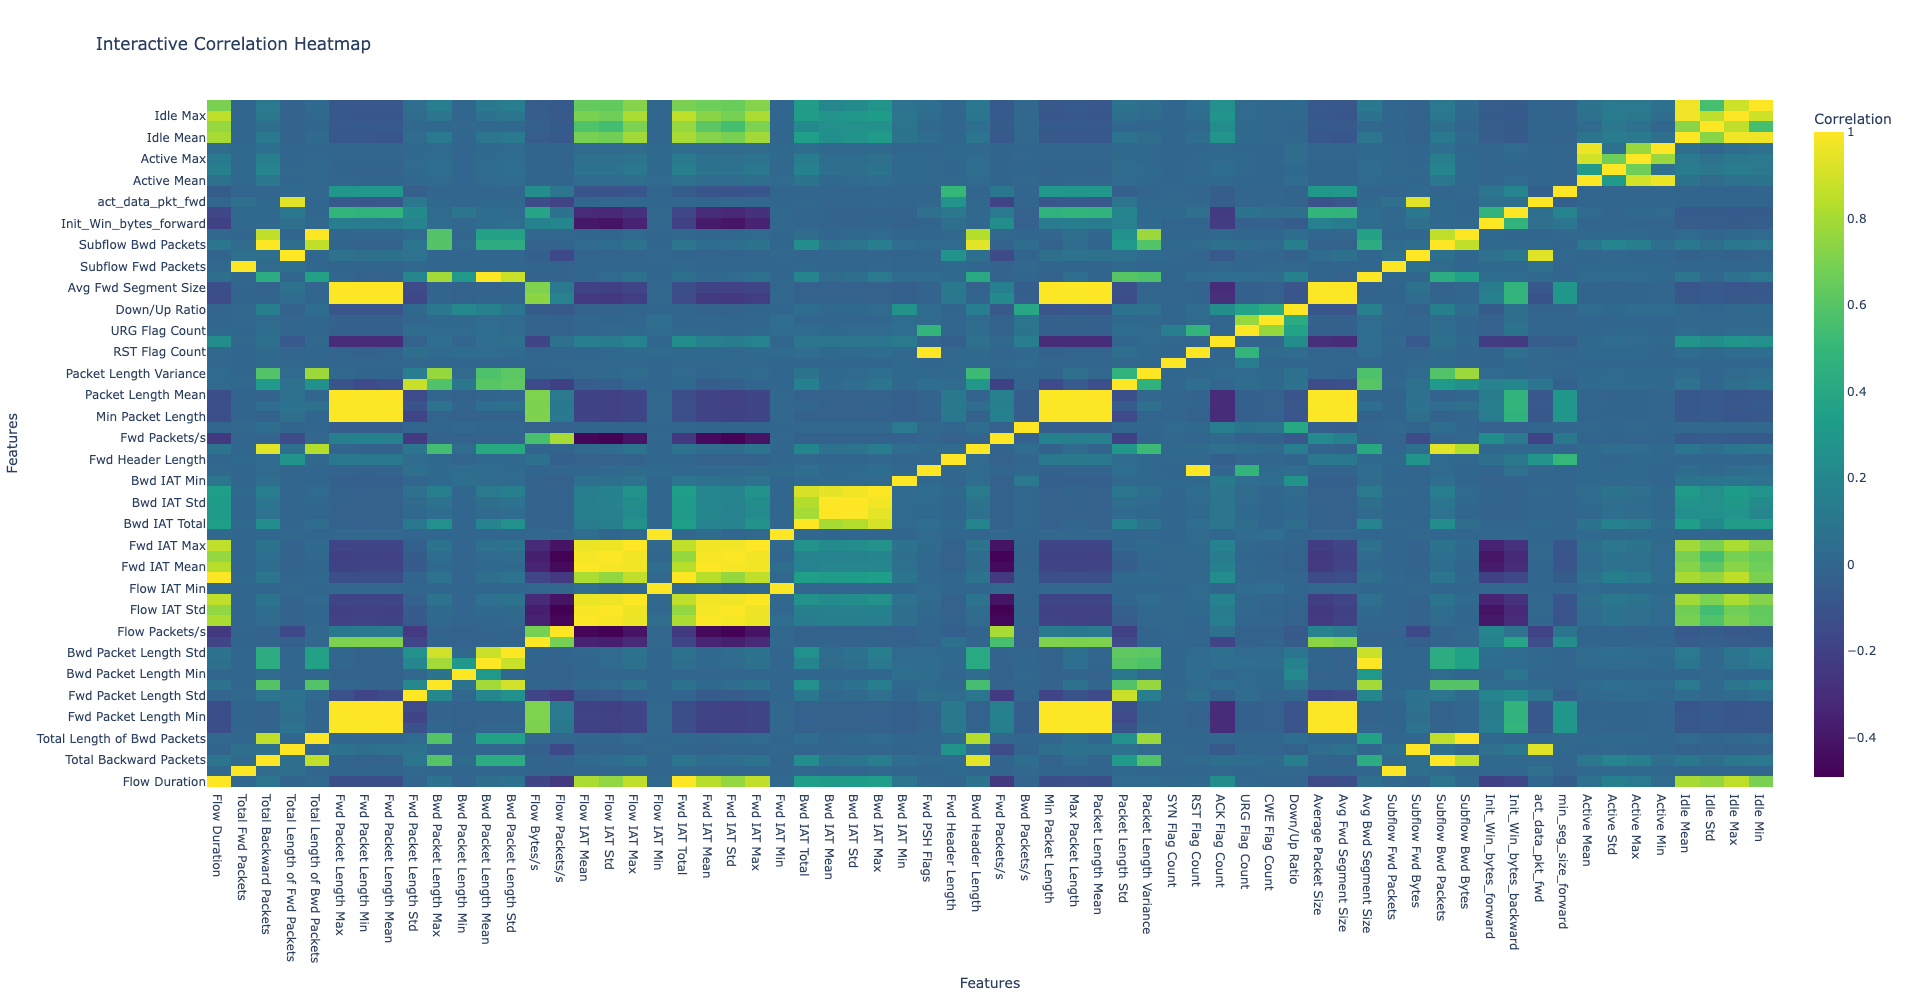

In [49]:
# Create a heatmap with Plotly
fig = go.Figure(data=go.Heatmap(
    z=corr_matrix.values,  # Correlation values
    x=corr_matrix.columns,  # Features on x-axis
    y=corr_matrix.columns,  # Features on y-axis
    colorscale='Viridis',   # Color scheme for the heatmap
    hoverongaps=False,      # Ensure no gaps in the hover data
    colorbar=dict(title="Correlation")
))

# Add title and layout configuration
fig.update_layout(
    title="Interactive Correlation Heatmap",
    xaxis_title="Features",
    yaxis_title="Features",
    autosize=False,
    width=1000,
    height=1000,
)

# Show the figure
fig.show()

In [51]:
%%time
benign_numeric_training_df = training_df[training_df['Label']=="BENIGN"].drop(columns=non_numerical_cols)
scaled_benign_numeric_training_df = scaler.transform(benign_numeric_training_df)
scaled_benign_numeric_training_df = pd.DataFrame(scaled_benign_numeric_training_df, columns=numeric_training_df.columns)
benign_corr_matrix = scaled_benign_numeric_training_df.corr()

CPU times: user 2 s, sys: 999 ms, total: 3 s
Wall time: 4.65 s


/opt/conda/lib/python3.10/site-packages/modin/pandas/dataframe.py:254: UserWarning:

Distributing <class 'numpy.ndarray'> object. This may take some time.



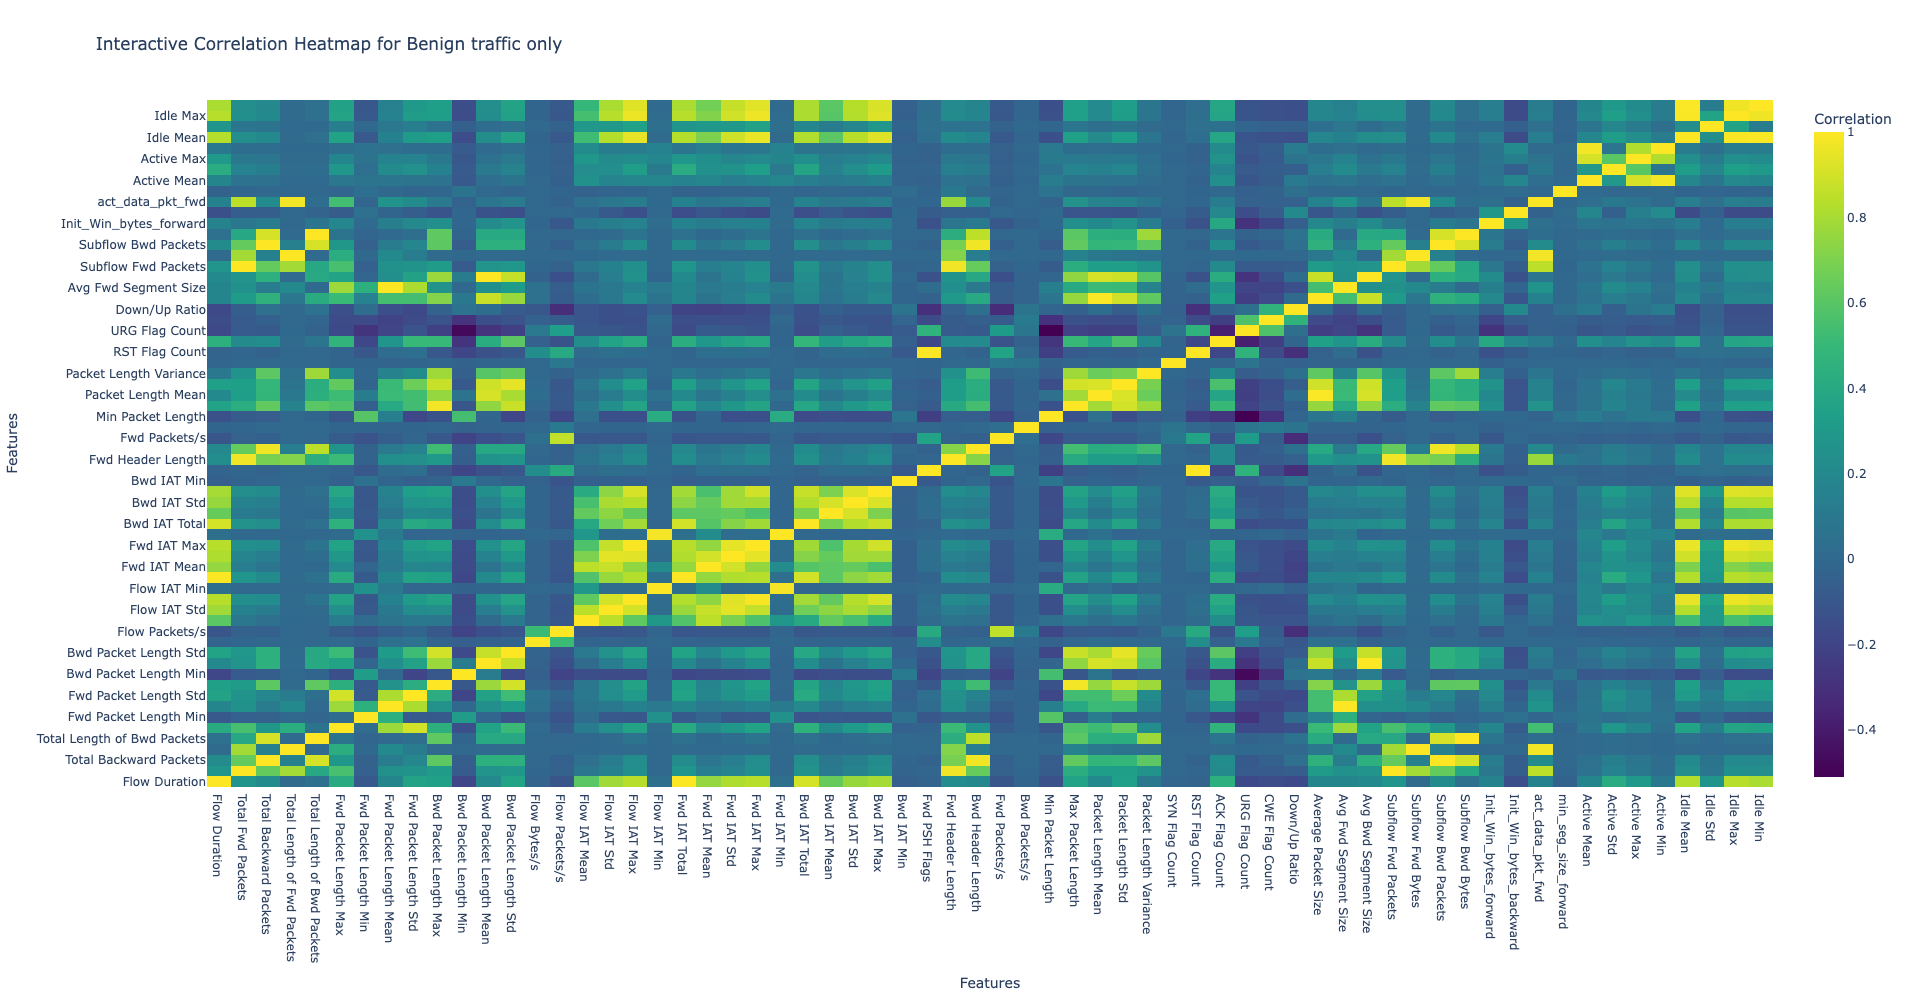

In [52]:
# Plotting the correlation for Benign data only:

# Create a heatmap with Plotly
fig = go.Figure(data=go.Heatmap(
    z=benign_corr_matrix.values,  # Correlation values
    x=benign_corr_matrix.columns,  # Features on x-axis
    y=benign_corr_matrix.columns,  # Features on y-axis
    colorscale='Viridis',   # Color scheme for the heatmap
    hoverongaps=False,      # Ensure no gaps in the hover data
    colorbar=dict(title="Correlation")
))

# Add title and layout configuration
fig.update_layout(
    title="Interactive Correlation Heatmap for Benign traffic only",
    xaxis_title="Features",
    yaxis_title="Features",
    autosize=False,
    width=1000,
    height=1000,
)

# Show the figure
fig.show()

In [53]:
attack_numeric_training_df = training_df[training_df['Label']!="BENIGN"].drop(columns=non_numerical_cols)
scaled_attack_numeric_training_df = scaler.transform(attack_numeric_training_df)
scaled_attack_numeric_training_df = pd.DataFrame(scaled_attack_numeric_training_df, columns=numeric_training_df.columns)
attack_corr_matrix = scaled_attack_numeric_training_df.corr()

/opt/conda/lib/python3.10/site-packages/modin/pandas/dataframe.py:254: UserWarning:

Distributing <class 'numpy.ndarray'> object. This may take some time.



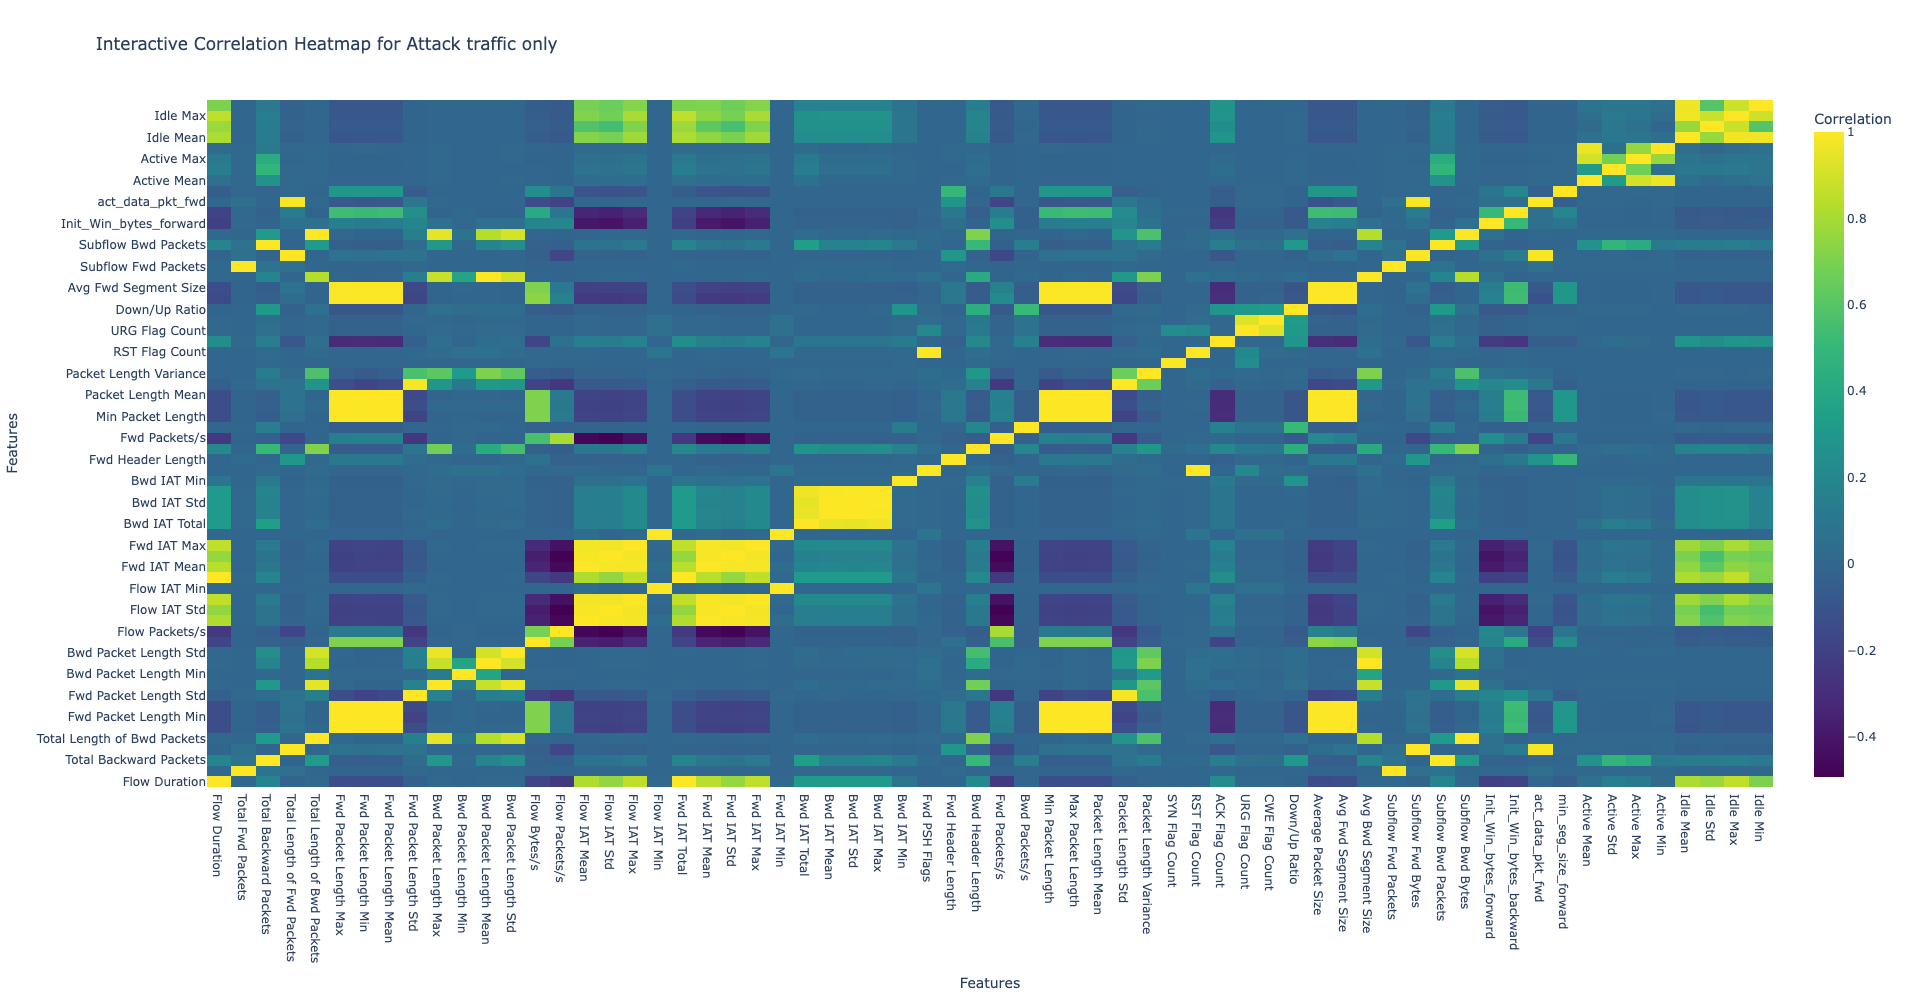

In [54]:
# Plotting the correlation for attack data only:

# Create a heatmap with Plotly
fig = go.Figure(data=go.Heatmap(
    z=attack_corr_matrix.values,  # Correlation values
    x=attack_corr_matrix.columns,  # Features on x-axis
    y=attack_corr_matrix.columns,  # Features on y-axis
    colorscale='Viridis',   # Color scheme for the heatmap
    hoverongaps=False,      # Ensure no gaps in the hover data
    colorbar=dict(title="Correlation")
))

# Add title and layout configuration
fig.update_layout(
    title="Interactive Correlation Heatmap for Attack traffic only",
    xaxis_title="Features",
    yaxis_title="Features",
    autosize=False,
    width=1000,
    height=1000,
)

# Show the figure
fig.show()

In [62]:
# Creating a correlation matrix with the mean of features correlation exceeding>0.95 on both Training and Testing Dataframe:
# Set a threshold for the correlations
threshold = 0.95

# Create boolean masks where correlations exceed the threshold in both matrices
benign_mask = benign_corr_matrix > threshold
attack_mask = attack_corr_matrix > threshold

# Combined mask where correlations exceed the threshold in both matrices
combined_mask = benign_mask & attack_mask

# Average the values in both matrices where the mask is True
average_corr_values = (benign_corr_matrix + attack_corr_matrix) / 2

# Apply the mask to the averaged matrix, keep only values where the mask is True
final_corr_matrix = average_corr_values.where(combined_mask)

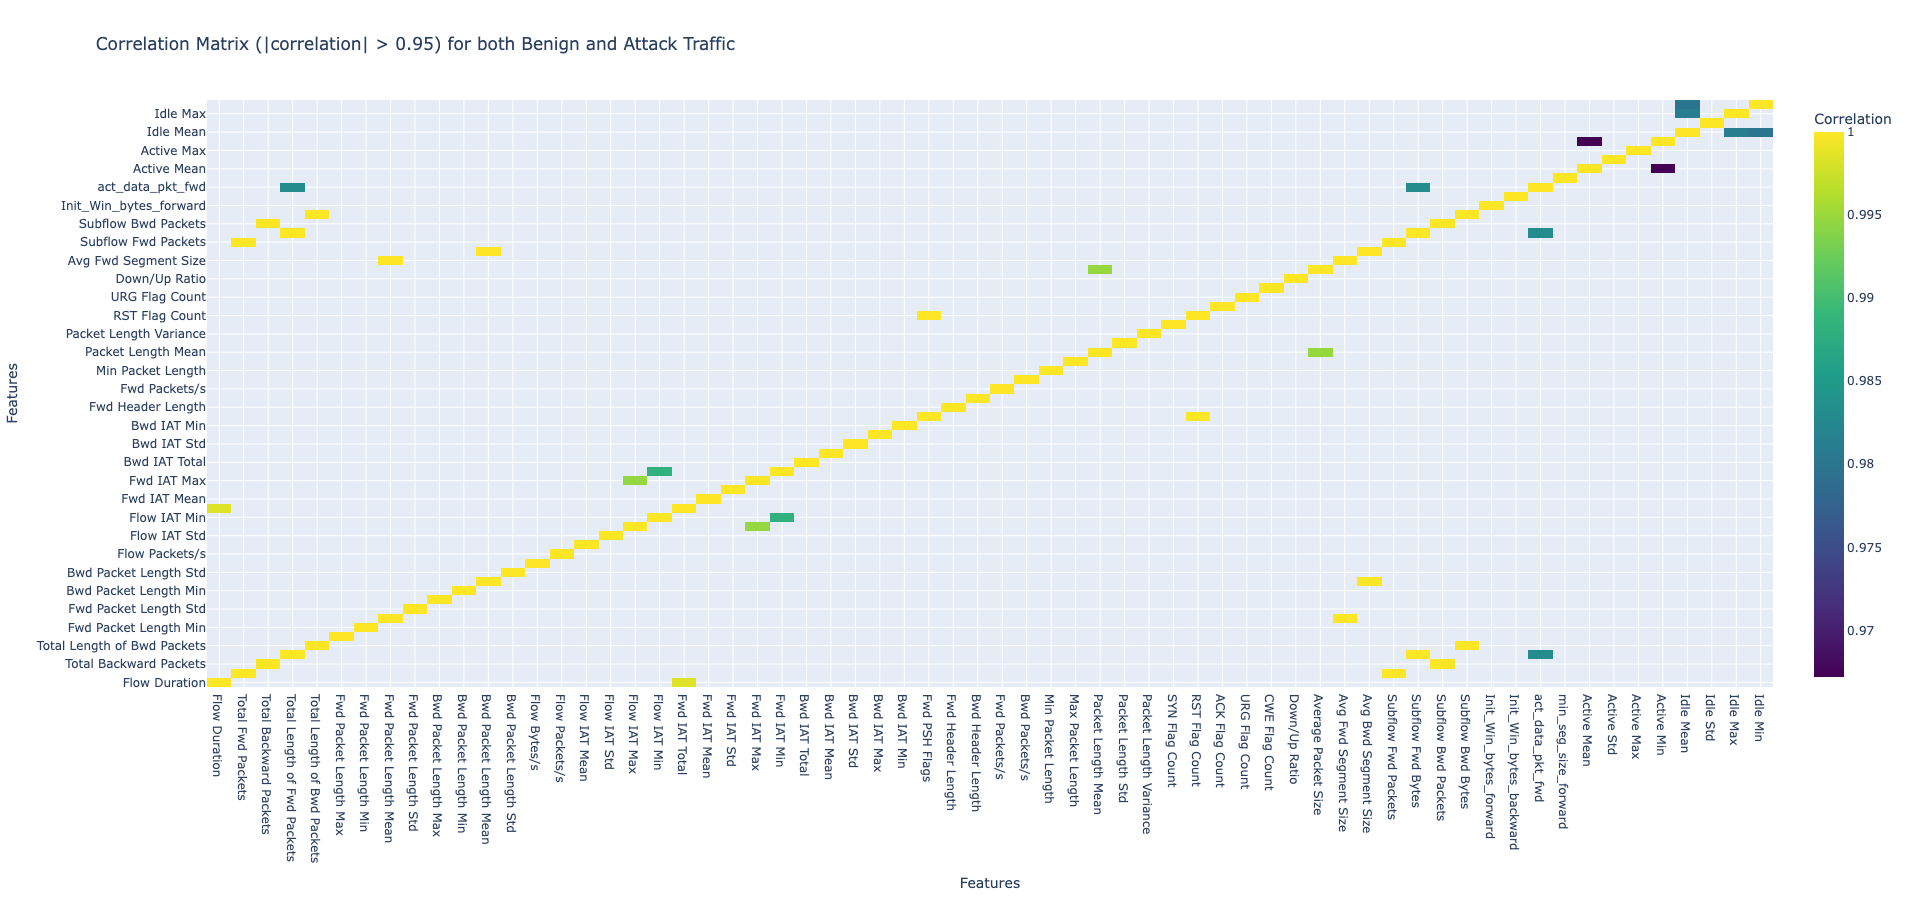

In [65]:
# Visualizing Features with Correlation exceeding 0.95 in both attack_corr_matrix and benign_corr_matric:

# Define the threshold for correlation
threshold = 0.95

fig = go.Figure(data=go.Heatmap(
    z=final_corr_matrix.values,  # Correlation values for the filtered subset
    x=final_corr_matrix.columns,  # Selected columns on x-axis
    y=final_corr_matrix.columns,  # Selected columns on y-axis
    colorscale='Viridis',          # Color scheme for the heatmap
    hoverongaps=False,             # Ensure no gaps in the hover data
    colorbar=dict(title="Correlation")
))

# Add title and layout configuration
fig.update_layout(
    title=f"Correlation Matrix (|correlation| > {threshold}) for both Benign and Attack Traffic",
    xaxis_title="Features",
    yaxis_title="Features",
    autosize=False,
    width=900,
    height=900,
)

# Show the figure
fig.show()

Findings: 

- Complete Match Corr = 1
    - "Subflow Fwd Packets", and "Total Fwd Packets" complete match.
    - "Subflow Bwd Packets", and "Total Backward Packets"
    - "Subflow Fwd Bytes", and "Total Length of Fwd Packets"
    - "Subflow Bwd Bytes", and "Total Length of Bwd Packets"
    - "Avg Fwd Segment Size", and "Fwd Packet Length Mean"
    - "Avg Bwd Segment Size", and "Bwd Packet Length Mean"
    - "RST Flag Count", and "Fwd PSH Flags"
    
 
- High Correlation:
    - "Flow Duration", "Fwd IAT Total" ; corr > 0.998
    - "Packet Length Mean", "Average Packet Size" ; corr > 0.994

Actions - Dropping columns:

"Subflow Fwd Packets",
"Subflow Bwd Packets",
"Subflow Fwd Bytes",
"Subflow Bwd Bytes",
"Avg Fwd Segment Size",
"Avg Bwd Segment Size",
"Fwd PSH Flags",
"Flow Duration",
"Packet Length Mean",

In [36]:
cols_to_drop = ["Subflow Fwd Packets", 
                "Subflow Bwd Packets", 
                "Subflow Fwd Bytes", 
                "Subflow Bwd Bytes", 
                "Avg Fwd Segment Size",  
                "Avg Bwd Segment Size", 
                "Fwd PSH Flags", 
                "Flow Duration", 
                "Packet Length Mean"
]

reduced_training_df = training_df.drop(columns=cols_to_drop)
reduced_testing_df = testing_df.drop(columns=cols_to_drop)

In [37]:
reduced_training_df.isna().sum().sum(), reduced_testing_df.isna().sum().sum()

(0, 0)

# 4. Handling Categorical data:

### 4.1. Source IP, Destination IP:

considered Ideas:

- Decode the class of the IP, e,g: Public/Private, Class A,B,C or D.
- Decode a bool feature if the IP belongs to reserved IP addresses.
- Check for which region, geography the IP belongs to:
    - Ethical consequences.
- Chek if the IP belongs to the network or not:
    - already satisfied by Inbound feature.
- Using Hash encoders: to encode IPs into 10 features
    - Problem: potential collosion, testing dataset doesn't have a wide range of IPs, leading to potential overfitting.   

In [51]:
(reduced_training_df["Source IP"].nunique(), reduced_training_df["Destination IP"].nunique())

(550, 598)

In [52]:
reduced_training_df["Source IP"].value_counts().head(20)

Source IP
172.16.0.5        49979501
192.168.50.1         16604
192.168.50.6         15580
192.168.50.7         15035
192.168.50.8         14692
74.208.236.171        1352
192.168.50.253         653
192.168.50.254         633
8.6.0.1                332
72.21.91.29            302
172.217.10.226         188
172.217.7.2            160
172.217.10.130         158
0.0.0.0                154
172.217.6.194          150
172.217.10.98          145
172.217.10.2           137
23.194.142.15          136
172.217.11.34          134
23.194.109.223         133
Name: count, dtype: int64

In [53]:
reduced_training_df["Destination IP"].value_counts().head(20)

Destination IP
192.168.50.1      49979610
4.2.2.4              16757
172.16.0.5           16243
8.8.8.8               4320
74.208.236.171        4260
192.168.50.8          3324
192.168.50.6          3034
192.168.50.7          2817
224.0.0.5             1272
72.21.91.29           1216
172.217.9.226          529
172.217.10.226         420
172.217.10.130         390
172.217.7.2            385
172.217.3.98           356
172.217.7.14           353
23.194.142.213         352
192.168.10.50          340
172.217.6.194          338
8.0.6.4                332
Name: count, dtype: int64

#### Findings:

Majority of the samples belongs to specific IPs, as a result of the test bed used to generate the data. Potential overfitting may occur specific to these IPs for any features that indicate the specific Source, or Destination IP.

#### Plan: 
a. Create a feature to highlight if the IP belongs to reserved IPs by [IANA](<https://www.iana.org/assignments/iana-ipv4-special-registry/iana-ipv4-special-registry.xhtml>)

b. Create a feature that indicate the [class of the IP](<https://www.rfc-editor.org/rfc/rfc4632.html#section-3.1>)
                                                        

#### 4.1.1. Creating a function to Encode IP addresses:

In [54]:
def encode_ip_features(df):
    
    # Create a copy of the input DataFrame to avoid modifying the original
    df_copy = df.copy()

    # defining constants 
    IP_CLASSES = ['A', 'B', 'C', 'D', 'E', 'Unknown']
    RESERVED_IP_CATEGORIES = ['Private', 'Multicast', 'Loopback', 'Link-local', 
                           'Reserved', 'Broadcast', 'DHCP/Zeros', 'Public']
    
    # Vectorized function to classify IP addresses based on the first octet
    def classify_ip_vectorized(ip_series):
        first_octet = ip_series.str.split('.').str[0].astype(int)
        conditions = [
            (first_octet >= 1) & (first_octet <= 126),
            (first_octet >= 128) & (first_octet <= 191),
            (first_octet >= 192) & (first_octet <= 223),
            (first_octet >= 224) & (first_octet <= 239),
            (first_octet >= 240) & (first_octet <= 255)
        ]
        choices = ['A', 'B', 'C', 'D', 'E']
        return np.select(conditions, choices, default='Unknown')

    # Vectorized function to classify reserved IP ranges
    def classify_reserved_ip_vectorized(ip_series):
        ip_objs = ip_series.apply(ipaddress.ip_address)
        return np.select(
            [
                ip_objs.apply(lambda ip: ip.is_private),
                ip_objs.apply(lambda ip: ip.is_multicast),
                ip_objs.apply(lambda ip: ip.is_loopback),
                ip_objs.apply(lambda ip: ip.is_link_local),
                ip_objs.apply(lambda ip: ip.is_reserved),
                ip_series == '255.255.255.255',
                ip_series == '0.0.0.0'
            ],
            [
                'Private', 'Multicast', 'Loopback', 'Link-local', 
                'Reserved', 'Broadcast', 'DHCP/Zeros'
            ],
            default='Public'
        )

    # Assign a Class to each IP Addresses:       
    # Apply vectorized classification to Source and Destination IPs
    df_copy['Source IP Class'] = classify_ip_vectorized(df_copy['Source IP'])
    df_copy['Destination IP Class'] = classify_ip_vectorized(df_copy['Destination IP'])

    # Convert to categorical to optimize memory usage
    df_copy['Source IP Class'] = pd.Categorical(df_copy['Source IP Class'], categories=IP_CLASSES)
    df_copy['Destination IP Class'] = pd.Categorical(df_copy['Destination IP Class'], categories=IP_CLASSES)

    # Check if IP address belongs to Reserved Category:
    # Apply vectorized reserved classification to Source and Destination IPs
    df_copy['Source IP Reserved'] = classify_reserved_ip_vectorized(df_copy['Source IP'])
    df_copy['Destination IP Reserved'] = classify_reserved_ip_vectorized(df_copy['Destination IP'])

    # Convert to categorical to optimize memory usage
    df_copy['Source IP Reserved'] = pd.Categorical(df_copy['Source IP Reserved'], categories=RESERVED_IP_CATEGORIES)
    df_copy['Destination IP Reserved'] = pd.Categorical(df_copy['Destination IP Reserved'], categories=RESERVED_IP_CATEGORIES)

    
    # Encode IP Class, and Reserved category:
    
    cols_to_encode = ['Source IP Class', 'Destination IP Class', 'Source IP Reserved', 'Destination IP Reserved']
    # Initialize OneHotEncoder with explicit categories for each feature
    encoder = OneHotEncoder(sparse_output=False, categories=[IP_CLASSES, IP_CLASSES, RESERVED_IP_CATEGORIES, RESERVED_IP_CATEGORIES])

    # Fit and transform the categorical features
    encoded_features = encoder.fit_transform(df_copy[cols_to_encode])
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(cols_to_encode))
    
    # Concatenate the encoded DataFrame with the original copy DataFrame
    df_copy.reset_index(drop=True, inplace=True)
    encoded_df.reset_index(drop=True, inplace=True)
    for col in encoded_df.columns:
        df_copy[col] = encoded_df[col]

    all_encoded_cols = cols_to_encode + ["Source IP", "Destination IP"]
    # Drop all encoded columns
    df_copy.drop(columns=all_encoded_cols, inplace=True)

    # Return the modified copy of the DataFrame
    return df_copy


#### 4.1.2. Testing the function created on a small dataframe:

In [55]:
small_df = training_df.sample(n=1000, random_state=123)

In [56]:
small_df.info()

<class 'modin.pandas.dataframe.DataFrame'>
Index: 1000 entries, 37345857 to 6115143
Data columns (total 74 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Source IP                    1000 non-null   category      
 1   Source Port                  1000 non-null   int32         
 2   Destination IP               1000 non-null   category      
 3   Destination Port             1000 non-null   int32         
 4   Protocol                     1000 non-null   category      
 5   Timestamp                    1000 non-null   datetime64[ns]
 6   Flow Duration                1000 non-null   int32         
 7   Total Fwd Packets            1000 non-null   int32         
 8   Total Backward Packets       1000 non-null   int16         
 9   Total Length of Fwd Packets  1000 non-null   float32       
 10  Total Length of Bwd Packets  1000 non-null   float32       
 11  Fwd Packet Length Max        1000

In [57]:
%%time
small_df = encode_ip_features(small_df)

CPU times: user 3.21 s, sys: 348 ms, total: 3.56 s
Wall time: 2.11 s


In [58]:
%%time
small_df.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 100 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Source Port                         1000 non-null   int32         
 1   Destination Port                    1000 non-null   int32         
 2   Protocol                            1000 non-null   category      
 3   Timestamp                           1000 non-null   datetime64[ns]
 4   Flow Duration                       1000 non-null   int32         
 5   Total Fwd Packets                   1000 non-null   int32         
 6   Total Backward Packets              1000 non-null   int16         
 7   Total Length of Fwd Packets         1000 non-null   float32       
 8   Total Length of Bwd Packets         1000 non-null   float32       
 9   Fwd Packet Length Max               1000 non-null   float32       
 10  Fwd Packet Length M

In [59]:
small_df.isna().sum().sum()

0

In [60]:
small_df.shape

(1000, 100)

In [61]:
small_df.iloc[:,60:80]

Active Mean  Active Std  Active Max  Active Min  Idle Mean  Idle Std  \
0            0.0         0.0         0.0         0.0        0.0       0.0   
1            0.0         0.0         0.0         0.0        0.0       0.0   
2            0.0         0.0         0.0         0.0        0.0       0.0   
3            0.0         0.0         0.0         0.0        0.0       0.0   
4            0.0         0.0         0.0         0.0        0.0       0.0   
..           ...         ...         ...         ...        ...       ...   
995          0.0         0.0         0.0         0.0        0.0       0.0   
996          0.0         0.0         0.0         0.0        0.0       0.0   
997          0.0         0.0         0.0         0.0        0.0       0.0   
998          0.0         0.0         0.0         0.0        0.0       0.0   
999          0.0         0.0         0.0         0.0        0.0       0.0   

     Idle Max  Idle Min SimillarHTTP  Inbound          Label  is_attack  \
0         0.0       0.0            0     True  DrDoS_NetBIOS       True   
1         0.0       0.0            0     True     DrDoS_LDAP       True   
2         0.0       0.0            0     True      DrDoS_DNS       True   
3         0.0       0.0            0     True           TFTP       True   
4         0.0       0.0            0     True     DrDoS_SNMP       True   
..        ...       ...          ...      ...            ...        ...   
995       0.0       0.0            0     True           TFTP       True   
996       0.0       0.0            0     True     DrDoS_LDAP       True   
997       0.0       0.0            0     True      DrDoS_DNS       True   
998       0.0       0.0            0     True     DrDoS_LDAP       True   
999       0.0       0.0            0     True           TFTP       True   

     Source IP Class_A  Source IP Class_B  Source IP Class_C  \
0                  0.0                1.0                0.0   
1                  0.0                1.0                0.0   
2                  0.0                1.0                0.0   
3                  0.0                1.0                0.0   
4                  0.0                1.0                0.0   
..                 ...                ...                ...   
995                0.0                1.0                0.0   
996                0.0                1.0                0.0   
997                0.0                1.0                0.0   
998                0.0                1.0                0.0   
999                0.0                1.0                0.0   

     Source IP Class_D  Source IP Class_E  Source IP Class_Unknown  \
0                  0.0                0.0                      0.0   
1                  0.0                0.0                      0.0   
2                  0.0                0.0                      0.0   
3                  0.0                0.0                      0.0   
4                  0.0                0.0                      0.0   
..                 ...                ...                      ...   
995                0.0                0.0                      0.0   
996                0.0                0.0                      0.0   
997                0.0                0.0                      0.0   
998                0.0                0.0                      0.0   
999                0.0                0.0                      0.0   

     Destination IP Class_A  Destination IP Class_B  
0                       0.0                     0.0  
1                       0.0                     0.0  
2                       0.0                     0.0  
3                       0.0                     0.0  
4                       0.0                     0.0  
..                      ...                     ...  
995                     0.0                     0.0  
996                     0.0                     0.0  
997                     0.0                     0.0  
998                     0.0  

In [62]:
small_df.columns

Index(['Source Port', 'Destination Port', 'Protocol', 'Timestamp',
       'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'SYN Flag Count', 'RST Flag Count', 'ACK Flag Co

#### 4.1.3. Applylying function to Train and testing datasets

In [63]:
%%time 

# applying this to Testing Dataframes:

reduced_testing_df = encode_ip_features(reduced_testing_df)

CPU times: user 1min 14s, sys: 19.3 s, total: 1min 34s
Wall time: 1min 16s


In [64]:
reduced_testing_df.columns

Index(['Source Port', 'Destination Port', 'Protocol', 'Timestamp',
       'Total Fwd Packets', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Std',
       'Packet Length Variance', 'SYN Flag Count', 'RST Flag Count',
       'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'Down/Up Ratio

In [65]:
reduced_testing_df.shape

(19963266, 91)

In [66]:
reduced_testing_df.isnull().sum().sum()

0

In [67]:
%%time

# applying this to Training Dataframes:

reduced_training_df = encode_ip_features(reduced_training_df)
reduced_training_df.columns

CPU times: user 2min 50s, sys: 45.9 s, total: 3min 35s
Wall time: 3min 14s


Index(['Source Port', 'Destination Port', 'Protocol', 'Timestamp',
       'Total Fwd Packets', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Std',
       'Packet Length Variance', 'SYN Flag Count', 'RST Flag Count',
       'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'Down/Up Ratio

In [68]:
reduced_training_df.shape

(50052497, 91)

In [69]:
reduced_training_df.columns

Index(['Source Port', 'Destination Port', 'Protocol', 'Timestamp',
       'Total Fwd Packets', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Std',
       'Packet Length Variance', 'SYN Flag Count', 'RST Flag Count',
       'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'Down/Up Ratio

In [70]:
reduced_training_df.isnull().sum().sum()

0

### 4.2. Source and Destination Port

In [71]:
reduced_training_df['Source Port'].value_counts()[1:20]

Source Port
564      696678
62468    682822
61850    611762
648      605499
62466    491661
62467    394222
62470    361756
900      356974
580      308782
634      227149
62474    214241
62472    181349
62480    167605
62476    157045
62469    147162
62478    147151
63493    138590
62482    136090
62484    126431
Name: count, dtype: int64

In [72]:
# Checking distribution of IANA assigned ports which are less than 100 

reduced_training_df[reduced_training_df['Source Port'] < 100]['Source Port'].value_counts()

Source Port
80    5863
0     2534
22    1913
68     155
53     134
69      20
25       1
81       1
Name: count, dtype: int64

In [73]:
# Checking distribution of IANA assigned ports which are less than 100 

reduced_training_df[reduced_training_df['Destination Port'] < 100]['Destination Port'].value_counts()

Destination Port
53    21749
80    14886
22     4792
0      2534
68     1323
      ...  
9       368
50      360
1       341
36      314
19       47
Name: count, Length: 100, dtype: int64

#### Plan:

Combing both Binary encoding and OneHot Encoder to avoid exceessive feature list, and ensuring important information on the port number is preserved and value properly in ML models. 

- Using Binary Encoding to encode the port numbers.
- In addition to that creating new features that represent whether a port belongs to assigned ports by IANA *(0-1023)* or if it is a Random port, and if it belongs to common applications, like SSH, HTTP, and HTTPS.

#### Creating a function and testing it on a small_df

In [74]:
reduced_training_df['Source Port'].between(0, 65535).all()

True

In [75]:
reduced_training_df['Destination Port'].between(0, 65535).all()

True

In [76]:
reduced_testing_df['Source Port'].between(0, 65535).all()

True

In [77]:
reduced_testing_df['Destination Port'].between(0, 65535).all()

True

In [78]:
def encode_ports(df):
    """
    Function to apply binary encoding, port category mapping, IANA range classification,
    and one-hot encoding, returning a new DataFrame without modifying the original.
    """
    
    # Create a deep copy of the input DataFrame to avoid modifying it in place
    df_copy = df.copy()

    # Step 0: Define port_value_mapping inside the function
    port_value_mapping = {
        0: "Zero", 20: "FTP", 21: "FTP", 22: "SSH", 80: "HTTP", 53: "DNS", 68: "DHCP", 69: "TFTP", 
        123: "NTP", 443: "HTTPS", 8080: "HTTP Alternate", 8443: "HTTPS Alternate", 1433: "MS SQL", 
        3306: "MySQL", 5432: "PostgreSQL", 3389: "RDP"
    }
    
    # Convert port_value_mapping to a pd.Series for fast vectorized lookup
    port_value_mapping_series = pd.Series(port_value_mapping)
    
    # Remove duplicate values from port_value_mapping
    unique_port_categories = sorted(set(port_value_mapping.values())) + ["Others"]

    # Step 1: Vectorized binary encoding for ports using NumPy
    source_port_binary = df_copy['Source Port'].apply(lambda x: np.array(list(np.binary_repr(x, width=16)), dtype=int))
    destination_port_binary = df_copy['Destination Port'].apply(lambda x: np.array(list(np.binary_repr(x, width=16)), dtype=int))

    # Expand the binary columns
    df_copy[[f'Source Port Binary_{i}' for i in range(16)]] = np.stack(source_port_binary.values)
    df_copy[[f'Destination Port Binary_{i}' for i in range(16)]] = np.stack(destination_port_binary.values)

    # Step 2: Vectorized port category mapping using map()
    # We fill missing values with "Others"
    df_copy['Source Port Category'] = df_copy['Source Port'].map(port_value_mapping_series).fillna("Others")
    df_copy['Destination Port Category'] = df_copy['Destination Port'].map(port_value_mapping_series).fillna("Others")

    # Step 3: Vectorized IANA range classification using pd.cut()
    iana_bins = [0, 1023, 49151, 65535, np.inf]
    iana_labels = ['Well-Known', 'Registered', 'Dynamic/Private', 'Unknown']

    df_copy['Source Port IANA Range'] = pd.cut(df_copy['Source Port'], bins=iana_bins, labels=iana_labels, right=True, include_lowest=True)
    df_copy['Destination Port IANA Range'] = pd.cut(df_copy['Destination Port'], bins=iana_bins, labels=iana_labels, right=True, include_lowest=True)

    # Step 4: One-hot encoding
    encoder = OneHotEncoder(sparse_output=False, categories=[
        unique_port_categories,  # Source Port Category
        unique_port_categories,  # Destination Port Category
        ['Well-Known', 'Registered', 'Dynamic/Private', 'Unknown'],  # Source Port IANA Range
        ['Well-Known', 'Registered', 'Dynamic/Private', 'Unknown']   # Destination Port IANA Range
    ])

    encoded_features = encoder.fit_transform(df_copy[['Source Port Category', 'Destination Port Category', 'Source Port IANA Range', 'Destination Port IANA Range']])
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['Source Port Category', 'Destination Port Category', 'Source Port IANA Range', 'Destination Port IANA Range']))

    # Concatenate the one-hot encoded columns back to the DataFrame copy
    df_copy = pd.concat([df_copy.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

    # Step 5: Drop the original port-related columns
    df_copy.drop(columns=['Source Port', 'Destination Port', 'Source Port Category', 'Destination Port Category', 
                          'Source Port IANA Range', 'Destination Port IANA Range'], inplace=True)

    return df_copy

In [79]:
small_df = training_df.sample(n=1000, random_state=123)

In [80]:
%%time
_ = encode_ports(small_df)
_.columns[-80:]

Please refer to https://modin.readthedocs.io/en/stable/supported_apis/defaulting_to_pandas.html for explanation.


CPU times: user 3.25 s, sys: 230 ms, total: 3.48 s
Wall time: 3.9 s


Index(['Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min', 'SimillarHTTP',
       'Inbound', 'Label', 'is_attack', 'Source Port Binary_0',
       'Source Port Binary_1', 'Source Port Binary_2', 'Source Port Binary_3',
       'Source Port Binary_4', 'Source Port Binary_5', 'Source Port Binary_6',
       'Source Port Binary_7', 'Source Port Binary_8', 'Source Port Binary_9',
       'Source Port Binary_10', 'Source Port Binary_11',
       'Source Port Binary_12', 'Source Port Binary_13',
       'Source Port Binary_14', 'Source Port Binary_15',
       'Destination Port Binary_0', 'Destination Port Binary_1',
       'Destination Port Binary_2', 'Destination Port Binary_3',
       'Destination Port Binary_4', 'Destination Port Binary_5',
       'Destination Port Binary_6', 'Destination Port Binary_7',
       'Destination Port Binary_8', 'Destination Port Binary_9',
       'Destination Port Binary_10', 'Destination Port Binary_11',
       'Destination Port Binary_12', 'Destination Port Binary_13

In [81]:
_.shape , small_df.shape

((1000, 144), (1000, 74))

In [82]:
_.isnull().sum()

Source IP                                      0
Destination IP                                 0
Protocol                                       0
Timestamp                                      0
Flow Duration                                  0
                                              ..
Source Port IANA Range_Unknown                 0
Destination Port IANA Range_Well-Known         0
Destination Port IANA Range_Registered         0
Destination Port IANA Range_Dynamic/Private    0
Destination Port IANA Range_Unknown            0
Length: 144, dtype: int64

##### Applying function to training and testing Dataset:


In [ ]:
%%time

encoded_testing_df = encode_ports(reduced_testing_df)
encoded_testing_df.shape

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


In [ ]:
encoded_testing_df.isnull().sum().sum()

In [ ]:
%%time

encoded_training_df = encode_ports(reduced_training_df)

In [ ]:
encoded_training_df.shape, reduced_training_df.shape

## 4.3. Checking columns in Training and Testing Datasets:

Checking the datatype of all columns in the dataset before going further. This helps to make the memory footprint of the dataframes more efficient.

In [ ]:
encoded_training_df.dtypes[:60]

In [ ]:
encoded_training_df.dtypes[60:120]

In [ ]:
encoded_training_df.dtypes[120:]

Fwd PSH Flags :  Number of times the PSH flag was set in packets traveling in the forward direction (0 for UDP).
SYN Flag Count:	Number of packets with SYN.
RST Flag Count:	Number of packets with RST.
PSH Flag Count:	Number of packets with PUSH.
ACK Flag Count:	Number of packets with ACK.
URG Flag Count:	Number of packets with URG.
CWE Flag Count: Number of packets with CWR.

Therefore, these columns should be numeric.

Timestamp should be datetime format, but it is handled in the next section.
Protocol, SimilarHTTP, and Label should be Categorical values, but all will be handled in later sections.

All the columns below  should be Booleans:

| Column Name                                | Data Type |
|--------------------------------------------|-----------|
| Source IP_Class A                          | float64   |
| Source IP_Class B                          | float64   |
| Source IP_Class C                          | float64   |
| Source IP_Class D                          | float64   |
| Source IP_Class E                          | float64   |
| Source IP_Class Unknown                    | float64   |
| Destination IP_Class A                     | float64   |
| Destination IP_Class B                     | float64   |
| Destination IP_Class C                     | float64   |
| Destination IP_Class D                     | float64   |
| Destination IP_Class E                     | float64   |
| Destination IP_Class Unknown               | float64   |
| Source IP Reserved_Private                 | float64   |
| Source IP Reserved_Multicast               | float64   |
| Source IP Reserved_Loopback                | float64   |
| Source IP Reserved_Link-local              | float64   |
| Source IP Reserved_Reserved                | float64   |
| Source IP Reserved_Broadcast               | float64   |
| Source IP Reserved_DHCP/Zeros              | float64   |
| Source IP Reserved_Public                  | float64   |
| Destination IP Reserved_Private            | float64   |
| Destination IP Reserved_Multicast          | float64   |
| Destination IP Reserved_Loopback           | float64   |
| Destination IP Reserved_Link-local         | float64   |
| Destination IP Reserved_Reserved           | float64   |
| Destination IP Reserved_Broadcast          | float64   |
| Destination IP Reserved_DHCP/Zeros         | float64   |
| Destination IP Reserved_Public             | float64   |
| Source Port Binary_0                       | int64     |
| Source Port Binary_1                       | int64     |
| Source Port Binary_2                       | int64     |
| Source Port Binary_3                       | int64     |
| Source Port Binary_4                       | int64     |
| Source Port Binary_5                       | int64     |
| Source Port Binary_6                       | int64     |
| Source Port Binary_7                       | int64     |
| Source Port Binary_8                       | int64     |
| Source Port Binary_9                       | int64     |
| Source Port Binary_10                      | int64     |
| Source Port Binary_11                      | int64     |
| Source Port Binary_12                      | int64     |
| Source Port Binary_13                      | int64     |
| Source Port Binary_14                      | int64     |
| Source Port Binary_15                      | int64     |
| Destination Port Binary_0                  | int64     |
| Destination Port Binary_1                  | int64     |
| Destination Port Binary_2                  | int64     |
| Destination Port Binary_3                  | int64     |
| Destination Port Binary_4                  | int64     |
| Destination Port Binary_5                  | int64     |
| Destination Port Binary_6                  | int64     |
| Destination Port Binary_7                  | int64     |
| Destination Port Binary_8                  | int64     |
| Destination Port Binary_9                  | int64     |
| Destination Port Binary_10                 | int64     |
| Destination Port Binary_11                 | int64     |
| Destination Port Binary_12                 | int64     |
| Destination Port Binary_13                 | int64     |
| Destination Port Binary_14                 | int64     |
| Destination Port Binary_15                 | int64     |
| Source Port Category_Zero                  | float64   |
| Source Port Category_FTP                   | float64   |
| Source Port Category_SSH                   | float64   |
| Source Port Category_HTTP                  | float64   |
| Source Port Category_DNS                   | float64   |
| Source Port Category_DHCP                  | float64   |
| Source Port Category_TFTP                  | float64   |
| Source Port Category_NTP                   | float64   |
| Source Port Category_HTTPS                 | float64   |
| Source Port Category_HTTP Alternate        | float64   |
| Source Port Category_HTTPS Alternate       | float64   |
| Source Port Category_MS SQL                | float64   |
| Source Port Category_MySQL                 | float64   |
| Source Port Category_PostgreSQL            | float64   |
| Source Port Category_RDP                   | float64   |
| Source Port Category_Others                | float64   |
| Destination Port Category_Zero             | float64   |
| Destination Port Category_FTP              | float64   |
| Destination Port Category_SSH              | float64   |
| Destination Port Category_HTTP             | float64   |
| Destination Port Category_DNS              | float64   |
| Destination Port Category_DHCP             | float64   |
| Destination Port Category_TFTP             | float64   |
| Destination Port Category_NTP              | float64   |
| Destination Port Category_HTTPS            | float64   |
| Destination Port Category_HTTP Alternate   | float64   |
| Destination Port Category_HTTPS Alternate  | float64   |
| Destination Port Category_MS SQL           | float64   |
| Destination Port Category_MySQL            | float64   |
| Destination Port Category_PostgreSQL       | float64   |
| Destination Port Category_RDP              | float64   |
| Destination Port Category_Others           | float64   |
| Source Port IANA Range_Well-Known          | float64   |
| Source Port IANA Range_Registered          | float64   |
| Source Port IANA Range_Dynamic/Private     | float64   |
| Source Port IANA Range_Unknown             | float64   |
| Destination Port IANA Range_Well-Known     | float64   |
| Destination Port IANA Range_Registered     | float64   |
| Destination Port IANA Range_Dynamic/Private| float64   |
| Destination Port IANA Range_Unknown        | float64   |


In [ ]:
cols_to_bool = ["Source IP Class_A","Source IP Class_B","Source IP Class_C","Source IP Class_D","Source IP Class_E","Source IP Class_Unknown",
                "Destination IP Class_A","Destination IP Class_B","Destination IP Class_C","Destination IP Class_D","Destination IP Class_E","Destination IP Class_Unknown",
                "Source IP Reserved_Private","Source IP Reserved_Multicast","Source IP Reserved_Loopback","Source IP Reserved_Link-local","Source IP Reserved_Reserved","Source IP Reserved_Broadcast",
                "Source IP Reserved_DHCP/Zeros","Source IP Reserved_Public","Destination IP Reserved_Private","Destination IP Reserved_Multicast" ,"Destination IP Reserved_Loopback",
                "Destination IP Reserved_Link-local","Destination IP Reserved_Reserved","Destination IP Reserved_Broadcast","Destination IP Reserved_DHCP/Zeros",
"Destination IP Reserved_Public", "Source Port Binary_0","Source Port Binary_1","Source Port Binary_2","Source Port Binary_3","Source Port Binary_4","Source Port Binary_5",
"Source Port Binary_6","Source Port Binary_7","Source Port Binary_8","Source Port Binary_9","Source Port Binary_10","Source Port Binary_11","Source Port Binary_12",
"Source Port Binary_13","Source Port Binary_14","Source Port Binary_15","Destination Port Binary_0","Destination Port Binary_1","Destination Port Binary_2",
"Destination Port Binary_3","Destination Port Binary_4","Destination Port Binary_5","Destination Port Binary_6","Destination Port Binary_7","Destination Port Binary_8",
"Destination Port Binary_9","Destination Port Binary_10","Destination Port Binary_11","Destination Port Binary_12","Destination Port Binary_13","Destination Port Binary_14",
"Destination Port Binary_15","Source Port Category_DHCP","Source Port Category_DNS","Source Port Category_FTP","Source Port Category_HTTP","Source Port Category_HTTP Alternate",
"Source Port Category_HTTPS","Source Port Category_HTTPS Alternate","Source Port Category_MS SQL","Source Port Category_MySQL","Source Port Category_NTP",
"Source Port Category_PostgreSQL","Source Port Category_RDP","Source Port Category_SSH","Source Port Category_TFTP","Source Port Category_Zero","Source Port Category_Others",
"Destination Port Category_DHCP","Destination Port Category_DNS","Destination Port Category_FTP","Destination Port Category_HTTP","Destination Port Category_HTTP Alternate",
"Destination Port Category_HTTPS","Destination Port Category_HTTPS Alternate","Destination Port Category_MS SQL","Destination Port Category_MySQL","Destination Port Category_NTP",
"Destination Port Category_PostgreSQL","Destination Port Category_RDP","Destination Port Category_SSH","Destination Port Category_TFTP","Destination Port Category_Zero",
"Destination Port Category_Others","Source Port IANA Range_Well-Known","Source Port IANA Range_Registered","Source Port IANA Range_Dynamic/Private","Source Port IANA Range_Unknown",
"Destination Port IANA Range_Well-Known","Destination Port IANA Range_Registered","Destination Port IANA Range_Dynamic/Private","Destination Port IANA Range_Unknown"]

encoded_training_df[cols_to_bool] = encoded_training_df[cols_to_bool].astype(bool)
encoded_testing_df[cols_to_bool] = encoded_testing_df[cols_to_bool].astype(bool)

In [ ]:
encoded_training_df.dtypes[0:60]

In [ ]:
encoded_training_df.dtypes[60:120]

In [ ]:
encoded_training_df.dtypes[120:]

## 4.4. Label:

Label feature will be removed, as "is_attack" would be considered the main target. 

In [ ]:
# remove Label column from both Training and Testing dataframes:
encoded_training_df.drop("Label", axis=1, inplace=True)
encoded_testing_df.drop("Label", axis=1, inplace=True)

## 4.5. Timestamp:

For timestamp, will remove the timestamp because the dataset contains features with aggregate statistical data on each flow. 
Additionally, for LSTM models, they can handle order sequentail data without a timestamp or oder field.

Moreover, encoding the timestamp to represent hours or days of the week, won't be effective approach as the data is generated in a single day, and DDoS attacks are launched at different date and time based on the attacker motives and the potential victim.

In [ ]:
# removing Timestamp from training and testing dataframes:
encoded_training_df.drop("Timestamp", axis=1, inplace=True)
encoded_testing_df.drop("Timestamp", axis=1, inplace=True)

In [ ]:
encoded_training_df.isna().sum().sum()

In [ ]:
encoded_testing_df.isna().sum().sum()

## 4.6. Protocol:

In [ ]:
encoded_testing_df["Protocol"].value_counts()

In [ ]:
encoded_training_df["Protocol"].value_counts()

In [ ]:
def encode_protocol_column(df):
    # Ensure the 'Protocol' column is of string type before encoding
    df['Protocol'] = df['Protocol'].astype(str)

    # Initialize the OneHotEncoder with categories for known protocol types
    encoder = OneHotEncoder(categories=[['HOPOPT', 'TCP', 'UDP']], sparse_output=False, dtype=bool)

    # Fit and transform the 'Protocol' column to binary columns
    protocol_encoded = encoder.fit_transform(df[['Protocol']])

    # Convert the encoded protocol into a DataFrame and name columns appropriately
    protocol_columns = encoder.get_feature_names_out(['Protocol'])
    protocol_encoded_df = pd.DataFrame(protocol_encoded, columns=protocol_columns)

    # Set dtype of the encoded columns to bool
    protocol_encoded_df = protocol_encoded_df.astype(bool)

    # Concatenate the new one-hot encoded columns with the original DataFrame
    df = pd.concat([df.reset_index(drop=True), protocol_encoded_df.reset_index(drop=True)], axis=1)

    # Return the modified DataFrame
    return df.drop(columns=['Protocol'])


In [ ]:
small_df = encoded_training_df.sample(n=1000, random_state=42)

In [ ]:
small_df = encode_protocol_column(small_df)

In [ ]:
small_df.columns

In [ ]:
small_df.isna().sum().sum()

In [ ]:
small_df.dtypes

In [ ]:
# applying this to Training and testing dataframes:

encoded_training_df = encode_protocol_column(encoded_training_df)
encoded_testing_df = encode_protocol_column(encoded_testing_df)


## 4.7. SimillarHTTP:

In [ ]:
encoded_training_df["SimillarHTTP"].value_counts()

In [ ]:
encoded_testing_df["SimillarHTTP"].value_counts()

In [ ]:
value_counts = encoded_training_df['SimillarHTTP'].value_counts()
repeated_values = value_counts[value_counts >= 5]
print(repeated_values)

it looks that SimillarHTTP column has URL Path accessed for HTTP request. 

Since the range of HTTP Path and URLs is infinite for benign traffic, and for attacks, it changes from a DDoS attack to another, this feature can be dropped to avoid confusion the model.

In [ ]:
encoded_training_df.drop(columns=["SimillarHTTP"],inplace=True)

In [ ]:
encoded_testing_df.drop(columns=["SimillarHTTP"],inplace=True)

# 5. Checking Dataframes after preparing them for Training and evaluation models:


In [ ]:
encoded_training_df.shape

In [ ]:
(encoded_training_df.shape, encoded_testing_df.shape)

In [ ]:
# Check if training_df and testing_df have the same columns, and with the same data types:

( (encoded_training_df.columns == encoded_testing_df.columns).all(), (encoded_training_df.dtypes == encoded_testing_df.dtypes).all() )

In [ ]:
def find_columns_with_different_dtypes(df1, df2):
    # Ensure both DataFrames have the same columns
    common_columns = set(df1.columns).intersection(set(df2.columns))
    
    # Dictionary to store columns with different data types
    diff_dtype_columns = {}
    
    for column in common_columns:
        if df1[column].dtype != df2[column].dtype:
            diff_dtype_columns[column] = (df1[column].dtype, df2[column].dtype)
    
    return diff_dtype_columns

In [ ]:
diff_dtypes = find_columns_with_different_dtypes(encoded_training_df, encoded_testing_df)

if diff_dtypes:
    print("Columns with different data types:")
    for col, dtypes in diff_dtypes.items():
        print(f"Column: {col}, Training DataType: {dtypes[0]}, Testing DataType: {dtypes[1]}")
else:
    print("All common columns have the same data types.")

# 6. Dropping columns with single value in both training and testing datasets:

In [ ]:
# Checking for columns with single value in training_df:

training_single_value_cols = [col for col in encoded_training_df.columns if training_df[col].nunique() <= 1]
test_single_value_cols = [col for col in encoded_testing_df.columns if training_df[col].nunique() <= 1]

In [ ]:
# compare test_single_value_cols to single_value_cols to check which columns exist in both, and which don't:

common_cols = set(single_value_cols).intersection(set(test_single_value_cols))
print(f"columns with single unqiue value in both training and testing dataset are: {common_cols}")
non_common_cols = set(single_value_cols).symmetric_difference(set(test_single_value_cols))
print(f"columns with single unqiue value in either training or testing dataset are: {non_common_cols}")

In [ ]:
(encoded_training_df.shape, encoded_training_df.shape)

In [ ]:
# dropping common_cols from training and testing datasets:

stripped_training_df = encoded_training_df.drop(columns=common_cols)
stripped_testing_df = encoded_testing_df.drop(columns=common_cols)
(training_df.shape, testing_df.shape)

In [ ]:
(training_df.shape, testing_df.shape)

# 7. Exporting Datasets:

In [ ]:
# Exporting these datasets as CSV files:
stripped_training_df.to_csv("/mnt/sagemaker-nvme/training_after_preproc.csv", index=False)
encoded_testing_df.to_csv("/mnt/sagemaker-nvme/testing_after_preproc.csv", index=False)

In [ ]:
# Uploading Training Dataframe to AWS Object Storage, S3, as NVMe storage is ephermal:

!aws s3 cp /mnt/sagemaker-nvme/training_after_preproc.csv s3://melbahae-capstone/Datasets/

In [ ]:
# Uploading Testing Dataframe to AWS Object Storage, S3, as NVMe storage is ephermal:

!aws s3 cp /mnt/sagemaker-nvme/testing_after_preproc.csv s3://melbahae-capstone/Datasets/